# PCA components filters (weights) and patterns (scores) visualization

### Imports

In [1]:
import os
import re
import glob
import os
import ast
import os.path as op
from collections import defaultdict
from copy import deepcopy
import copy

import pickle
from time import time
import pywt
import mne
import scipy
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
import cesium.featurize
from plotly.subplots import make_subplots
from ipywidgets import Dropdown, FloatRangeSlider, IntSlider, FloatSlider, interact
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.base import TransformerMixin, BaseEstimator

import sys

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.svm import SVR
from sklearn.decomposition import FastICA
from sklearn.decomposition import PCA
import mne

import matplotlib.pyplot as plt
import seaborn as sns

from rumination_experiment_transformers_averaged_CDS import *

import warnings

warnings.filterwarnings("ignore")


---
## Load data

Loading EEG data and data from rumination questionnaire. By default create_df_data loads all info from given file but one can specify it by passing a list of desired labels from csv file.

In [2]:
# paths TODO
dir_path = os.path.dirname(os.path.abspath(""))

Constants

In [3]:
tmin, tmax = -0.1, 0.6  # Start and end of the segments

signal_frequency = 256
ERROR = 0
CORRECT = 1
random_state = 0

In [4]:
def create_df_data(
    test_participants=False,
    test_epochs=False,
    info_filename=None,
    info="all",
    personal=True,
):
    """Loads data for all participants and create DataFrame with optional additional info from given .csv file.

    On default, loads a train set: chooses only 80% of participants
    and for each of them chooses 80% of epochs.
    It will choose them deterministically.

    Participants with less than 10 epochs per condition are rejected.

    If test_participants is set to True, it will load remaining 20% of participants.
    If test_epochs is set to True, it will load remaining 20% of epochs.
    Test epochs are chronologically after train epochs,
    because it reflects real usage (first callibration and then classification).

    Parameters
    ----------
    test_participants: bool
        whether load data for training or final testing.
        If true load participants data for testing.
    test_epochs: bool
        whether load data for training or final testing.
        If true load epochs of each participants data for testing.
    info_filename: String | None
        path to .csv file with additional data.
    info: array
        listed parameters from the info file to be loaded.
        if 'all', load all parameters
    personal: bool
        whether a model will be both trained and tested on epochs from one person
        if false, person's epochs aren't split into test and train


    Returns
    -------
    go_nogo_data_df : pandas.DataFrame

    """
    print(os.path.abspath(""))
    dir_path = os.path.dirname(os.path.abspath(""))
    print(dir_path)
    header_files_glob = os.path.join(dir_path, "data/responses_100_600/*.vhdr")
    header_files = glob.glob(header_files_glob)

    header_files = sorted(header_files)
    go_nogo_data_df = pd.DataFrame()

    # cut 20% of data for testing
    h_train, h_test = train_test_split(header_files, test_size=0.3, random_state=0)
    
    print(f"train size: {len(h_train)} ; test size: {len(h_test)}")

    if test_participants:
        header_files = h_test
    else:
        header_files = h_train

    for file in header_files:
        #  load eeg data for given participant
        participant_epochs = load_epochs_from_file(file)

        # and compute participant's id from file_name
        participant_id = re.match(r".*_(\w+).*", file).group(1)

        error = participant_epochs["error_response"]._data
        correct = participant_epochs["correct_response"]._data

        # exclude those participants who have too few samples
        if len(error) < 5 or len(correct) < 5:
            # not enough data for this participant
            continue

        # construct dataframe for participant with: id|epoch_data|response_type|additional info...
        participant_df = create_df_from_epochs(
            participant_id, participant_epochs, info_filename, info
        )
        print(participant_id)
        go_nogo_data_df = go_nogo_data_df.append(participant_df, ignore_index=True)

    return go_nogo_data_df

In [5]:
def create_df_from_epochs(id, participant_epochs, info_filename, info):
    """Create df for each participant. DF structure is like: {id: String ; epoch: epoch_data ; marker: 1.0|0.0}
    1.0 means correct and 0.0 means error response.
    Default info extracted form .csv file is 'Rumination Full Scale' and participants' ids.
    With this info df structure is like:
    {id: String ; epoch: epoch_data ; marker: 1.0|0.0 ; File: id ; 'Rumination Full Scale': int}

    Parameters
    ----------
    id: String
        participant's id extracted from filename
    correct: array
        correct responses' data
    error: array
        error responses' data
    info_filename: String
        path to .csv file with additional data.
    info: array
        listed parameters from the info file to be loaded.
        if 'all', load all parameters

    Returns
    -------
    participant_df : pandas.DataFrame

    """
    participant_df = pd.DataFrame()
    info_df = pd.DataFrame()

    # get additional info from file
    if info_filename is not None:
        if info == "all":
            rumination_df = pd.read_csv(info_filename)
        else:
            rumination_df = pd.read_csv(info_filename, usecols=["Demo_kod"] + info)
        info_df = (
            rumination_df.loc[rumination_df["Demo_kod"] == id]
            .reset_index()
            .drop("index", axis=1)
        )
        
    epoch_df = pd.DataFrame({"id": [id], "epoch": [participant_epochs], "marker": [ALL]}).join(
            info_df
        )
    participant_df = participant_df.append(epoch_df, ignore_index=True)

    return participant_df

In [6]:
def load_epochs_from_file(file, reject_bad_segments="auto", mask=None):
    """Load epochs from a header file.

    Args:
        file: path to a header file (.vhdr)
        reject_bad_segments: 'auto' means that bad segments are rejected automatically.

    Returns:
        mne Epochs

    """
    # Import the BrainVision data into an MNE Raw object
    raw = mne.io.read_raw_brainvision(file)

    # Construct annotation filename
    annot_file = file[:-4] + "vmrk"

    # Read in the event information as MNE annotations
    annotations = mne.read_annotations(annot_file)

    # Add the annotations to our raw object so we can use them with the data
    raw.set_annotations(annotations)

    # Map with response markers only
    event_dict = {
        "Stimulus/RE*ex*1_n*1_c_1*R*FB": 10004,
        "Stimulus/RE*ex*1_n*1_c_1*R*FG": 10005,
        "Stimulus/RE*ex*1_n*1_c_2*R": 10006,
        "Stimulus/RE*ex*1_n*2_c_1*R": 10007,
        "Stimulus/RE*ex*2_n*1_c_1*R": 10008,
        "Stimulus/RE*ex*2_n*2_c_1*R*FB": 10009,
        "Stimulus/RE*ex*2_n*2_c_1*R*FG": 10010,
        "Stimulus/RE*ex*2_n*2_c_2*R": 10011,
    }

    # Map for merged correct/error response markers
    merged_event_dict = {"correct_response": 0, "error_response": 1}

    # Reconstruct the original events from Raw object
    events, event_ids = mne.events_from_annotations(raw, event_id=event_dict)

    # Merge correct/error response events
    merged_events = mne.merge_events(
        events,
        [10004, 10005, 10009, 10010],
        merged_event_dict["correct_response"],
        replace_events=True,
    )
    merged_events = mne.merge_events(
        merged_events,
        [10006, 10007, 10008, 10011],
        merged_event_dict["error_response"],
        replace_events=True,
    )

    epochs = []
    bads = []
    this_reject_by_annotation = True
    
    # maximum acceptable peak-to-peak amplitudes
    reject_criteria = dict(eeg=150e-6)       # 200 µV
    
    # minimum acceptable peak-to-peak amplitudes
    flat_criteria = dict(eeg=1e-6)           # 1 µV
    
    picks_eeg = mne.pick_types(raw.info, meg=False, eeg=True, eog=False,
                           stim=False, exclude='bads', selection=red_box7_prim)

    # Read epochs
    epochs = mne.Epochs(
        raw=raw,
        events=merged_events,
        event_id=merged_event_dict,
        tmin=tmin,
        tmax=tmax,
        baseline=None,
        reject_by_annotation=this_reject_by_annotation,
        preload=True,
        # verbose='CRITICAL',
    )
    
    return epochs

#### Read the training data

In [7]:
df_name = "go_nogo_100_600_df_3-5_all_scales"
pickled_data_filename = "../data/responses_100_600_pickled/" + df_name + ".pkl"
info_filename = "../data/scales/all_scales.csv"

# Check if data is already loaded
if os.path.isfile(pickled_data_filename):
    print("Pickled file found. Loading pickled data...")
    epochs_df = pd.read_pickle(pickled_data_filename)
    print("Done")
    pass
else:
    print("Pickled file not found. Loading data...")
    epochs_df = create_df_data(
        test_participants=False, info="all", personal=False, info_filename=info_filename
    )
    epochs_df.name = df_name
    # save loaded data into a pickle file
    epochs_df.to_pickle("../data/" + epochs_df.name + ".pkl")
    print("Done. Pickle file created")

Pickled file found. Loading pickled data...
Done


#### Read the testing data

In [8]:
df_name = "go_nogo_100_600_test_df_3-5_all_scales"
pickled_data_filename = "../data/responses_100_600_pickled/" + df_name + ".pkl"
info_filename = "../data/scales/all_scales.csv"


# Check if data is already loaded
if os.path.isfile(pickled_data_filename):
    print("Pickled file found. Loading pickled data...")
    epochs_test_df = pd.read_pickle(pickled_data_filename)
    print("Done")
else:
    print("Pickled file not found. Loading data...")
    epochs_test_df = create_df_data(
        test_participants=True, info="all", personal=False, info_filename=info_filename
    )
    epochs_test_df.name = df_name
    # save loaded data into a pickle file
    epochs_test_df.to_pickle("../data/responses_100_600_pickled/" + epochs_test_df.name + ".pkl")
    print("Done. Pickle file created")

Pickled file found. Loading pickled data...
Done


## Create pipeline

In [17]:
min_spatial_filter = 3
max_spatial_filter = 5
step_spatial_filter = 1


roi_1 = [
    "Fpz", 
    "AFz",
    "Fz",
    "FCz",
    "Cz",
    "CPz",
    "P1", "Pz", "P2",
]


roi_2 = [
    "Fpz", 
    "AFz",
    "F1", "Fz", "F2",
    "FCz",
    "C1", "Cz","C2",
    "CPz",
    "P1", "Pz", "P2",
]

roi_list = [roi_1, roi_2]

In [18]:
X_train_df = epochs_df

In [19]:
X_train_df_copy = pd.DataFrame(copy.deepcopy(X_train_df.to_dict()))
roi = roi_2

preprocessed_pipeline = Pipeline([
    # ("channels_extraction",PickChannels(channels_list=roi)),
    ("average", Evoked()),
    # ('extract_averaged_data', ExtractData()),
    # ("spatial_filter_preprocessing", SpatialFilterPreprocessing()),
    # ("spatial_filter",PCA(n_components=n_components, random_state=random_state)),
    # ("spatial_filter_postprocessing",SpatialFilterPostprocessing(timepoints_count=timepoints_count)),
    # ("lowpass_filter", LowpassFilter()),
    # ("binning", BinTransformer(step=this_bin)),
    # ("centering", CenteredSignalAfterBaseline3()) 
]).fit(X_train_df_copy)

In [20]:
preprocessed_X = preprocessed_pipeline.transform(X_train_df_copy)

In [21]:
epochs = preprocessed_X.iloc[0].epoch

In [22]:
epochs

Number of events,206
Events,correct_response: 200error_response: 6
Time range,-0.102 – 0.602 sec
Baseline,off


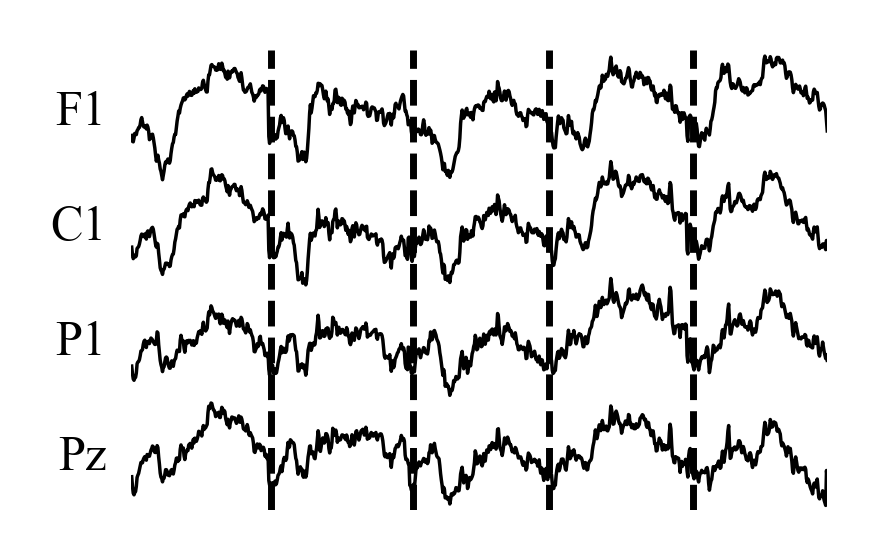

In [158]:
import matplotlib.ticker as ticker

cm = 1/2.54
dpi = 500

plt.rcParams['figure.dpi'] = dpi
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize'] = 7
plt.rcParams['xtick.labelsize'] = 7
plt.rcParams['axes.labelsize'] = 7
plt.rcParams["axes.edgecolor"] = ".15"
plt.rcParams["axes.linewidth"]  = 1
# plt.rcParams["figure.figsize"] = (5*cm, 5*cm)
plt.rc('font', size=7)
plt.rcParams["figure.frameon"] = False
    
event_dict = {"correct_response": 0, "error_response": 1}

fig = epochs['error_response'].plot(
    picks= roi_2,
    event_id=event_dict,
    event_color=dict(error_response="red"),
    scalings=dict(mag=1e-12, grad=4e-11, eeg=35e-6, eog=150e-6, ecg=5e-4,
     emg=1e-3, ref_meg=1e-12, misc=1e-3, stim=1,
     resp=1, chpi=1e-4, whitened=1e2),
    n_epochs=5,
    n_channels=4,
    epoch_colors=[['blue']*64,['red']*64, ['orange']*64, ['green']*64, ['purple']*64,['pink']*64],
    show_scrollbars=False,
    show_scalebars=False,
    show=False,
)
ax = fig.axes[0]

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.tick_params(size=0)
fig.axes[0].get_xaxis().set_visible(False)
fig.axes[0].get_xaxis().set_ticks([])

ax.axvline(x=0.71, color='black', linestyle='--', linewidth = 1, alpha=1)
ax.axvline(x=1.43, color='black', linestyle='--', linewidth = 1, alpha=1)
ax.axvline(x=2.12, color='black', linestyle='--', linewidth = 1, alpha=1)
ax.axvline(x=2.85, color='black', linestyle='--', linewidth = 1, alpha=1)


fig.set_size_inches(6*cm, 3.7*cm) 

plt.show()
# fig.savefig(f'step_1_roi_dark', bbox_inches='tight')

- PCA

In [177]:
X_train_df_copy = pd.DataFrame(copy.deepcopy(X_train_df.to_dict()))
roi = roi_2

preprocessed_pipeline = Pipeline([
    ("channels_extraction",PickChannels(channels_list=roi)),
    ("average", Evoked()),
    ('extract_averaged_data', ExtractData()),
    ("spatial_filter_preprocessing", SpatialFilterPreprocessing()),
    ("spatial_filter",PCA(n_components=4, random_state=random_state)),
    ("spatial_filter_postprocessing",SpatialFilterPostprocessing(timepoints_count=181)),
    ("lowpass_filter", LowpassFilter()),
    # ("binning", BinTransformer(step=this_bin)),
    # ("centering", CenteredSignalAfterBaseline3()) 
]).fit(X_train_df_copy)

(96, 13, 181)


In [274]:
X_df_copy = pd.DataFrame(copy.deepcopy(X_train_df.to_dict()))
X = X_df_copy

# extract PCA components (eigenvectors)
components = preprocessed_pipeline['spatial_filter'].components_

# create MNE object with sensors within ROI
epochs_full = mne.concatenate_epochs([epoch['error_response'] for epoch in X_df_copy.epoch.to_list()])
epochs_full = epochs_full.pick_channels(roi, ordered=True)

# compute grand average of EEG signal within ROI
data = np.array([epoch['error_response'].get_data(picks=roi) for epoch in X.epoch.to_list()])
print(data.shape)

this_data = []

for participant in data:
    this_epochs = []
    for epoch in participant:
        # print(epoch.shape)
        X_patterns = np.array([(epoch.T * component).T for component in components])
        # print(X_patterns.shape)
        patterns_grand_averages = np.array([np.mean(pattern, axis=0) for pattern in X_patterns])
        patterns_grand_averages[1] = patterns_grand_averages[1] * 1.7
        patterns_grand_averages[2] = patterns_grand_averages[2] * 5
        patterns_grand_averages[3] = patterns_grand_averages[3] * 10
        # print(patterns_grand_averages.shape)
        this_epochs.append(patterns_grand_averages)
    this_data.append(this_epochs)

    
    
# for participant in 
# # create components scores (patterns)
# X_patterns = np.array([(X_channels_mean * component).T for component in components])

Not setting metadata
1635 matching events found
No baseline correction applied
(96,)


In [275]:
info = mne.create_info(
    ch_names = ['PCA 1', 'PCA 2', 'PCA 3', 'PCA 4'],
    sfreq = 256.00
)
info

<Info | 7 non-empty values
 bads: []
 ch_names: PCA 1, PCA 2, PCA 3, PCA 4
 chs: 4 misc
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 128.0 Hz
 meas_date: unspecified
 nchan: 4
 projs: []
 sfreq: 256.0 Hz
>

In [ ]:
patterns_epochs = np.array([mne.EpochsArray(pattern, info, tmin=epochs_full.tmin) for pattern in this_data])

In [277]:
pattern_epoch = patterns_epochs[0]

In [278]:
pattern_epoch

Number of events,6
Events,1: 6
Time range,-0.102 – 0.602 sec
Baseline,off


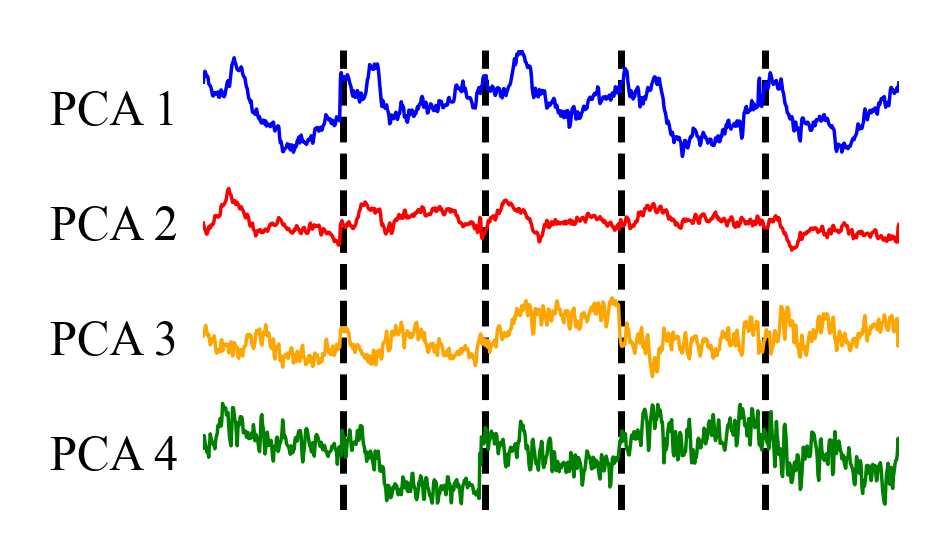

In [285]:
import matplotlib.ticker as ticker

cm = 1/2.54
dpi = 500

plt.rcParams['figure.dpi'] = dpi
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize'] = 7
plt.rcParams['xtick.labelsize'] = 7
plt.rcParams['axes.labelsize'] = 7
plt.rcParams["axes.edgecolor"] = ".15"
plt.rcParams["axes.linewidth"]  = 1
# plt.rcParams["figure.figsize"] = (5*cm, 5*cm)
plt.rc('font', size=7)
plt.rcParams["figure.frameon"] = False
    
# event_dict = {"correct_response": 0, "error_response": 1}

fig = pattern_epoch.plot(
    picks= ['PCA 1', 'PCA 2', 'PCA 3', 'PCA 4'],
    # event_id=event_dict,
    # event_color=dict(error_response="red"),
    scalings=dict(misc=10e-6),
    n_epochs=5,
    n_channels=4,
    # epoch_colors=[['blue']*4,['red']*4, ['orange']*4, ['green']*4, ['purple']*4,['pink']*4],
    epoch_colors=[['blue', 'red', 'orange', 'green']]*6,
    show_scrollbars=False,
    show_scalebars=False,
    show=False,
)
ax = fig.axes[0]

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.tick_params(size=0)
fig.axes[0].get_xaxis().set_visible(False)
fig.axes[0].get_xaxis().set_ticks([])

ax.axvline(x=0.71, color='black', linestyle='--', linewidth = 1, alpha=1)
ax.axvline(x=1.43, color='black', linestyle='--', linewidth = 1, alpha=1)
ax.axvline(x=2.12, color='black', linestyle='--', linewidth = 1, alpha=1)
ax.axvline(x=2.85, color='black', linestyle='--', linewidth = 1, alpha=1)


fig.set_size_inches(6*cm, 3.7*cm) 

plt.show()
fig.savefig(f'step_2_pca_colors', bbox_inches='tight')

- average

In [223]:
X_train_df_copy = pd.DataFrame(copy.deepcopy(X_train_df.to_dict()))
roi = roi_2

preprocessed_pipeline = Pipeline([
    ("channels_extraction",PickChannels(channels_list=roi)),
    ("average", Evoked()),
    ('extract_averaged_data', ExtractData()),
    ("spatial_filter_preprocessing", SpatialFilterPreprocessing()),
    ("spatial_filter",PCA(n_components=4, random_state=random_state)),
    ("spatial_filter_postprocessing",SpatialFilterPostprocessing(timepoints_count=181)),
    ("lowpass_filter", LowpassFilter2(cutoff=30)),
    # ("binning", BinTransformer(step=this_bin)),
    # ("centering", CenteredSignalAfterBaseline3()) 
]).fit(X_train_df_copy)

(96, 13, 181)


In [224]:
preprocessed_X = preprocessed_pipeline.transform(X_train_df_copy)
preprocessed_X.shape

(96, 13, 181)


(96, 4, 181)

In [225]:
preprocessed_X_3 = preprocessed_X[40:]

In [226]:
for participant in preprocessed_X_3:
    participant[1] = participant[1] * 1.7
    participant[2] = participant[2] * 5
    participant[3] = participant[3] * 10

In [227]:
info = mne.create_info(
    ch_names = ['PCA 1', 'PCA 2', 'PCA 3', 'PCA 4'],
    sfreq = 256.00,
)

In [228]:
patterns_epochs = mne.EpochsArray(preprocessed_X_3, info, tmin=epochs.tmin)

Not setting metadata
56 matching events found
No baseline correction applied
0 projection items activated


In [229]:
patterns_epochs

Number of events,56
Events,1: 56
Time range,-0.102 – 0.602 sec
Baseline,off


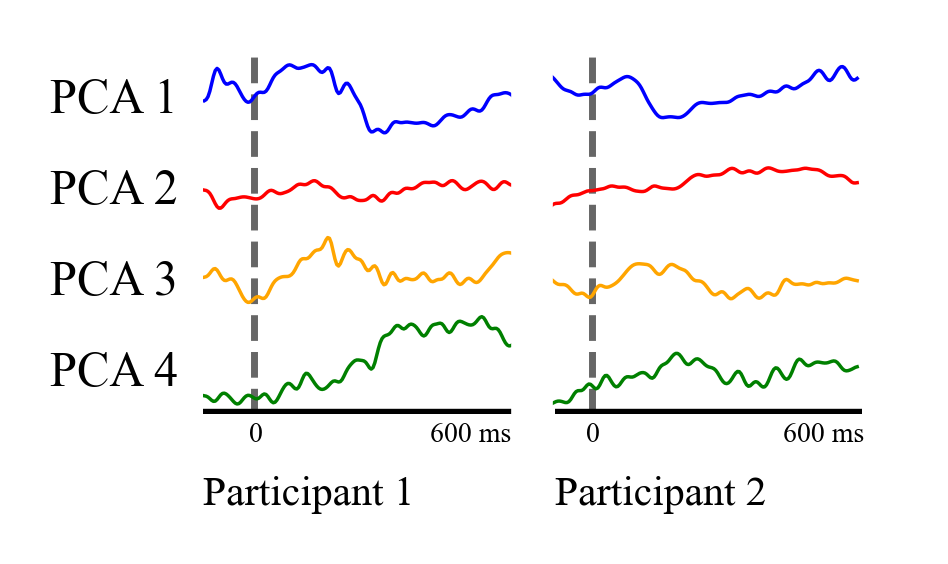

In [33]:
import matplotlib.ticker as ticker

cm = 1/2.54
dpi = 500

plt.rcParams['figure.dpi'] = dpi
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize'] = 7
plt.rcParams['xtick.labelsize'] = 7
plt.rcParams['axes.labelsize'] = 7
plt.rcParams["axes.edgecolor"] = ".15"
plt.rcParams["axes.linewidth"]  = 1
# plt.rcParams["figure.figsize"] = (5*cm, 5*cm)
plt.rc('font', size=7)
plt.rcParams["figure.frameon"] = False
    
# event_dict = {"correct_response": 0, "error_response": 1}

fig = patterns_epochs.plot(
    picks= ['PCA 1', 'PCA 2', 'PCA 3', 'PCA 4'],
    # event_id=event_dict,
    # event_color=dict(error_response="red"),
    scalings=dict(misc=50e-6),
    n_epochs=2,
    n_channels=4,
    # epoch_colors=[['blue']*4,['red']*4, ['orange']*4, ['green']*4, ['purple']*4,['pink']*4],
    epoch_colors=[['blue', 'red', 'orange', 'green']]*len(patterns_epochs),
    show_scrollbars=False,
    show_scalebars=False,
    show=False,
)
ax = fig.axes[0]

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.tick_params(size=0)
fig.axes[0].get_xaxis().set_visible(False)
fig.axes[0].get_xaxis().set_ticks([0.1,0.2, 0.3, 1.5])

ax.axvline(x=0.71, color='white', linestyle='-', linewidth = 6, alpha=1, zorder=100000)
ax.axvline(x=0.11, color='black', linestyle='--', linewidth = 1, alpha=0.6)
ax.axvline(x=0.84, color='black', linestyle='--', linewidth = 1, alpha=0.6)


ax.text(0, 4.5, 'Participant 1', fontsize = 6, zorder=100000000000, )
ax.text(0.76, 4.5, 'Participant 2', fontsize = 6, zorder=100000000000, )

# ax.axhline(y=3.5, color='black', linestyle='-', linewidth = 1, alpha=1, zorder=100000)
ax.hlines(3.5, 0, 0.68,  color='black', linestyle='-', linewidth = 1.5)
ax.hlines(3.5, 0.76, 1.42,  color='black', linestyle='-', linewidth = 1.5)

ax.text(0.1, 3.8, '0', fontsize = 4, zorder=100000000000, )
ax.text(0.49, 3.8, '600 ms', fontsize = 4, zorder=100000000000, )

ax.text(0.825, 3.8, '0', fontsize = 4, zorder=100000000000, )
ax.text(1.25, 3.8, '600 ms', fontsize = 4, zorder=100000000000, )

fig.set_size_inches(6*cm, 3.2*cm) 

plt.show()
fig.savefig(f'step_3_averages_colors', bbox_inches='tight')

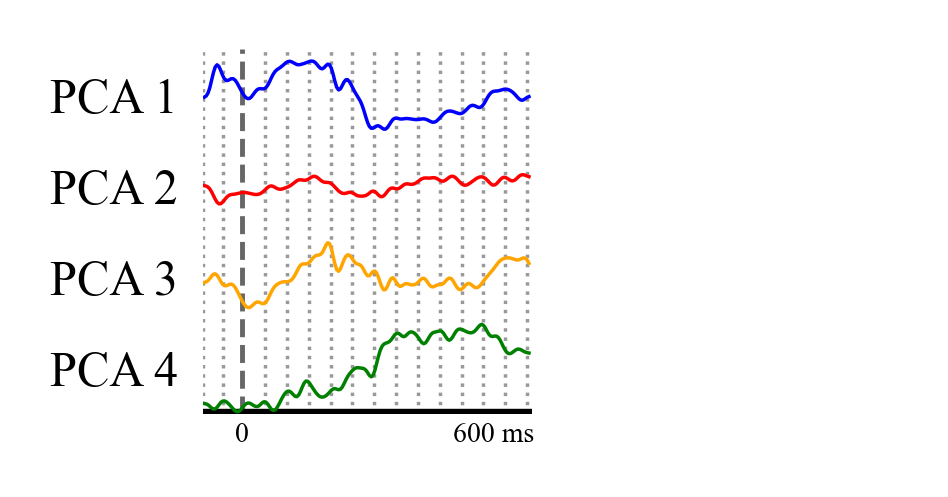

In [232]:
import matplotlib.ticker as ticker

cm = 1/2.54
dpi = 500

plt.rcParams['figure.dpi'] = dpi
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize'] = 7
plt.rcParams['xtick.labelsize'] = 7
plt.rcParams['axes.labelsize'] = 7
plt.rcParams["axes.edgecolor"] = ".15"
plt.rcParams["axes.linewidth"]  = 1
# plt.rcParams["figure.figsize"] = (5*cm, 5*cm)
plt.rc('font', size=7)
plt.rcParams["figure.frameon"] = False
    
# event_dict = {"correct_response": 0, "error_response": 1}

fig = patterns_epochs.plot(
    picks= ['PCA 1', 'PCA 2', 'PCA 3', 'PCA 4'],
    # event_id=event_dict,
    # event_color=dict(error_response="red"),
    scalings=dict(misc=50e-6),
    n_epochs=1,
    n_channels=4,
    # epoch_colors=[['blue']*4,['red']*4, ['orange']*4, ['green']*4, ['purple']*4,['pink']*4],
    epoch_colors=[['blue', 'red', 'orange', 'green']]*len(patterns_epochs),
    show_scrollbars=False,
    show_scalebars=False,
    show=False,
)
ax = fig.axes[0]

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.tick_params(size=0)
fig.axes[0].get_xaxis().set_visible(False)
fig.axes[0].get_xaxis().set_ticks([0.1,0.2, 0.3, 1.5])

ax.axvline(x=0.086, color='black', linestyle='--', linewidth = 0.7, alpha=0.6) ## 0

ax.axvline(x=0.0, color='black', linestyle='dotted', linewidth = 0.5, alpha=0.4)
ax.axvline(x=0.043, color='black', linestyle='dotted', linewidth = 0.5, alpha=0.4)

num=13
step=0.047
start=0.135

for i in np.arange(0,num)*step+start:
    ax.axvline(x=i, color='black', linestyle='dotted', linewidth = 0.5, alpha=0.4)
    

# ax.text(0.03, 4.5, 'Participant 1', fontsize = 6, zorder=100000000000, )

ax.hlines(3.5, 0, 0.71,  color='black', linestyle='-', linewidth = 1.5)


ax.text(0.07, 3.8, '0', fontsize = 4, zorder=100000000000, )
ax.text(0.54, 3.8, '600 ms', fontsize = 4, zorder=100000000000, )


fig.set_size_inches(6*cm, 3.2*cm) 

plt.show()
fig.savefig(f'step_3-5_averages_colors', bbox_inches='tight')

In [ ]:
ax.axvline(x=0.0, color='black', linestyle='dotted', linewidth = 0.5, alpha=0.4)
ax.axvline(x=0.043, color='black', linestyle='dotted', linewidth = 0.5, alpha=0.4)

num=13
step=0.047
start=0.135

for i in np.arange(0,num)*step+start:
    ax.axvline(x=i, color='black', linestyle='dotted', linewidth = 0.5, alpha=0.4)

- binning

In [234]:
X_train_df_copy = pd.DataFrame(copy.deepcopy(X_train_df.to_dict()))
roi = roi_2

preprocessed_pipeline = Pipeline([
    ("channels_extraction",PickChannels(channels_list=roi)),
    ("average", Evoked()),
    ('extract_averaged_data', ExtractData()),
    ("spatial_filter_preprocessing", SpatialFilterPreprocessing()),
    ("spatial_filter",PCA(n_components=4, random_state=random_state)),
    ("spatial_filter_postprocessing",SpatialFilterPostprocessing(timepoints_count=181)),
    ("lowpass_filter", LowpassFilter2(cutoff=30)),
    ("binning", BinTransformer(step=12)),
    # ("centering", CenteredSignalAfterBaseline3()) 
]).fit(X_train_df_copy)

(96, 13, 181)


In [235]:
preprocessed_X = preprocessed_pipeline.transform(X_train_df_copy)
preprocessed_X.shape

(96, 13, 181)


(96, 4, 15)

In [236]:
for participant in preprocessed_X:
    participant[1] = participant[1] * 5
    participant[2] = participant[2] * 8
    participant[3] = participant[3] * 10

In [237]:
preprocessed_X_3 = preprocessed_X[40:]

In [238]:
this_data = []
for participant in preprocessed_X_3:
    this_participant = []
    for component in participant:
        this_component = []
        for value in component:
            this_value_array = [value]*12
            this_component.append(this_value_array)
        this_participant.append(np.array(this_component).flatten())
    this_data.append(this_participant)

In [239]:
this_data = np.array(this_data)
this_data.shape

(56, 4, 180)

In [240]:
info = mne.create_info(
    ch_names = ['PCA 1', 'PCA 2', 'PCA 3', 'PCA 4'],
    sfreq = 256.0,
)

In [241]:
patterns_epochs = mne.EpochsArray(this_data, info, tmin=epochs.tmin)

Not setting metadata
56 matching events found
No baseline correction applied
0 projection items activated


In [242]:
# import matplotlib.ticker as ticker

# cm = 1/2.54
# dpi = 500

# plt.rcParams['figure.dpi'] = dpi
# plt.rcParams["font.family"] = "Times New Roman"
# plt.rcParams['ytick.labelsize'] = 7
# plt.rcParams['xtick.labelsize'] = 7
# plt.rcParams['axes.labelsize'] = 7
# plt.rcParams["axes.edgecolor"] = ".15"
# plt.rcParams["axes.linewidth"]  = 1
# # plt.rcParams["figure.figsize"] = (5*cm, 5*cm)
# plt.rc('font', size=7)
# plt.rcParams["figure.frameon"] = False
    
# # event_dict = {"correct_response": 0, "error_response": 1}

# fig = patterns_epochs.plot(
#     picks= ['PCA 1', 'PCA 2', 'PCA 3', 'PCA 4'],
#     # event_id=event_dict,
#     # event_color=dict(error_response="red"),
#     scalings=dict(misc=50e-6),
#     n_epochs=2,
#     n_channels=4,
#     # epoch_colors=[['blue']*4,['red']*4, ['orange']*4, ['green']*4, ['purple']*4,['pink']*4],
#     epoch_colors=[['blue', 'red', 'orange', 'green']]*len(preprocessed_X_3),
#     show_scrollbars=False,
#     show_scalebars=False,
#     show=False,
# )
# ax = fig.axes[0]

# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)

# ax.tick_params(size=0)
# fig.axes[0].get_xaxis().set_visible(False)
# fig.axes[0].get_xaxis().set_ticks([0.1,0.2, 0.3, 1.5])

# ax.axvline(x=0.71, color='white', linestyle='-', linewidth = 5, alpha=1, zorder=100000)
# ax.axvline(x=0.11, color='black', linestyle='--', linewidth = 1, alpha=0.6)
# ax.axvline(x=0.84, color='black', linestyle='--', linewidth = 1, alpha=0.6)


# ax.text(0, 4.5, 'Participant 1', fontsize = 6, zorder=100000000000, )
# ax.text(0.76, 4.5, 'Participant 2', fontsize = 6, zorder=100000000000, )

# ax.hlines(3.5, 0.04, 0.68,  color='black', linestyle='-', linewidth = 1.5)
# ax.hlines(3.5, 0.76, 1.33,  color='black', linestyle='-', linewidth = 1.5)

# ax.text(0.1, 3.8, '0', fontsize = 4, zorder=100000000000, )
# ax.text(0.49, 3.8, '600 ms', fontsize = 4, zorder=100000000000, )

# ax.text(0.825, 3.8, '0', fontsize = 4, zorder=100000000000, )
# ax.text(1.25, 3.8, '600 ms', fontsize = 4, zorder=100000000000, )

# fig.set_size_inches(6*cm, 3.2*cm) 

# plt.show()
# # fig.savefig(f'step_4_binning_colors', bbox_inches='tight')

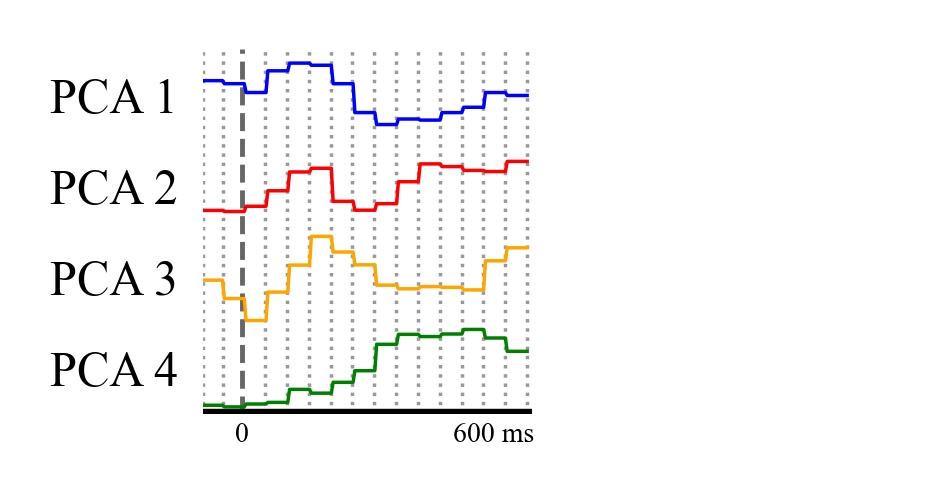

In [126]:
import matplotlib.ticker as ticker

cm = 1/2.54
dpi = 500

plt.rcParams['figure.dpi'] = dpi
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize'] = 7
plt.rcParams['xtick.labelsize'] = 7
plt.rcParams['axes.labelsize'] = 7
plt.rcParams["axes.edgecolor"] = ".15"
plt.rcParams["axes.linewidth"]  = 1
# plt.rcParams["figure.figsize"] = (5*cm, 5*cm)
plt.rc('font', size=7)
plt.rcParams["figure.frameon"] = False
    
# event_dict = {"correct_response": 0, "error_response": 1}

fig = patterns_epochs.plot(
    picks= ['PCA 1', 'PCA 2', 'PCA 3', 'PCA 4'],
    # event_id=event_dict,
    # event_color=dict(error_response="red"),
    scalings=dict(misc=50e-6),
    n_epochs=1,
    n_channels=4,
    # epoch_colors=[['blue']*4,['red']*4, ['orange']*4, ['green']*4, ['purple']*4,['pink']*4],
    epoch_colors=[['blue', 'red', 'orange', 'green']]*len(preprocessed_X_3),
    show_scrollbars=False,
    show_scalebars=False,
    show=False,
)
ax = fig.axes[0]

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.tick_params(size=0)
fig.axes[0].get_xaxis().set_visible(False)
fig.axes[0].get_xaxis().set_ticks([0.1,0.2, 0.3, 1.5])

ax.axvline(x=0.086, color='black', linestyle='--', linewidth = 0.7, alpha=0.6) ## 0

ax.axvline(x=0.0, color='black', linestyle='dotted', linewidth = 0.5, alpha=0.4)
ax.axvline(x=0.043, color='black', linestyle='dotted', linewidth = 0.5, alpha=0.4)

num=13
step=0.047
start=0.135

for i in np.arange(0,num)*step+start:
    ax.axvline(x=i, color='black', linestyle='dotted', linewidth = 0.5, alpha=0.4)
    

# ax.text(0.03, 4.5, 'Participant 1', fontsize = 6, zorder=100000000000, )

ax.hlines(3.5, 0, 0.71,  color='black', linestyle='-', linewidth = 1.5)


ax.text(0.07, 3.8, '0', fontsize = 4, zorder=100000000000, )
ax.text(0.54, 3.8, '600 ms', fontsize = 4, zorder=100000000000, )



fig.set_size_inches(6*cm, 3.2*cm) 

plt.show()
fig.savefig(f'step_4_binning_long_one_colors_2', bbox_inches='tight')

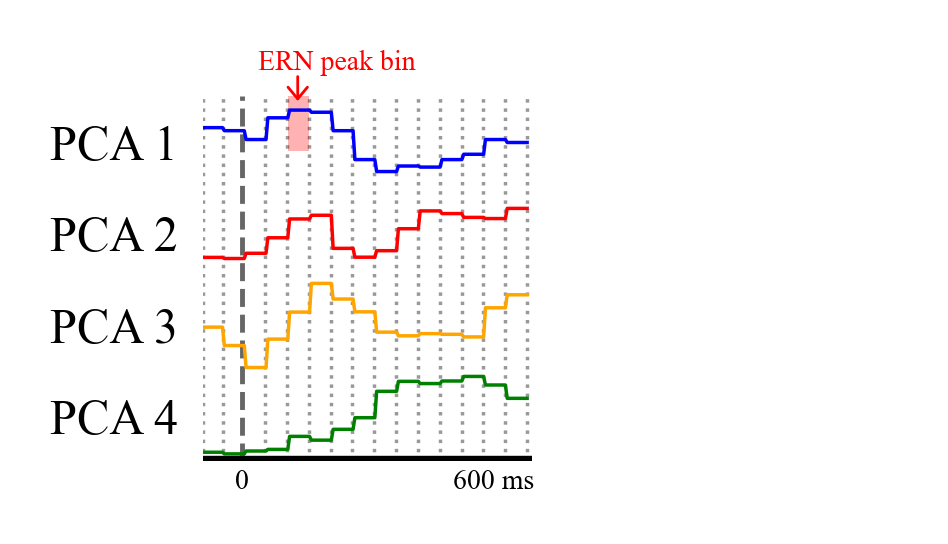

In [220]:
import matplotlib.ticker as ticker

cm = 1/2.54
dpi = 500

plt.rcParams['figure.dpi'] = dpi
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize'] = 7
plt.rcParams['xtick.labelsize'] = 7
plt.rcParams['axes.labelsize'] = 7
plt.rcParams["axes.edgecolor"] = ".15"
plt.rcParams["axes.linewidth"]  = 1
# plt.rcParams["figure.figsize"] = (5*cm, 5*cm)
plt.rc('font', size=7)
plt.rcParams["figure.frameon"] = False
    
# event_dict = {"correct_response": 0, "error_response": 1}

fig = patterns_epochs.plot(
    picks= ['PCA 1', 'PCA 2', 'PCA 3', 'PCA 4'],
    # event_id=event_dict,
    # event_color=dict(error_response="red"),
    scalings=dict(misc=50e-6),
    n_epochs=1,
    n_channels=4,
    # epoch_colors=[['blue']*4,['red']*4, ['orange']*4, ['green']*4, ['purple']*4,['pink']*4],
    epoch_colors=[['blue', 'red', 'orange', 'green']]*len(preprocessed_X_3),
    show_scrollbars=False,
    show_scalebars=False,
    show=False,
)
ax = fig.axes[0]

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.tick_params(size=0)
fig.axes[0].get_xaxis().set_visible(False)
fig.axes[0].get_xaxis().set_ticks([0.1,0.2, 0.3, 1.5])

ax.axvline(x=0.086, color='black', linestyle='--', linewidth = 0.7, alpha=0.6) ## 0

ax.axvline(x=0.0, color='black', linestyle='dotted', linewidth = 0.5, alpha=0.4)
ax.axvline(x=0.043, color='black', linestyle='dotted', linewidth = 0.5, alpha=0.4)

num=13
step=0.047
start=0.135

for i in np.arange(0,num)*step+start:
    ax.axvline(x=i, color='black', linestyle='dotted', linewidth = 0.5, alpha=0.4)


ax.hlines(3.5, 0, 0.71,  color='black', linestyle='-', linewidth = 1.5)

ax.text(0.07, 3.8, '0', fontsize = 4, zorder=100000000000, )
ax.text(0.54, 3.8, '600 ms', fontsize = 4, zorder=100000000000, )

ax.axvspan(0.183, 0.229, ymin=0.85, ymax=1, color='red', alpha=0.3, linestyle='-', linewidth=0)
# ax.axvline(x=0.18, color='red', linestyle='-', linewidth = 1, alpha=0.6)
ax.text(0.12, -0.8, f'ERN peak bin', fontsize = 4, zorder=100000000000, color='red')

ax.annotate("", xy=(0.205, -0.3), xytext=(0.205, -0.87), arrowprops=dict(arrowstyle="->", color="red", linewidth=0.4, mutation_aspect=0.6),
            
           )

fig.set_size_inches(6*cm, 3.2*cm) 

plt.show()
fig.savefig(f'step_5_set_peak_long_sub_one_colors', bbox_inches='tight')

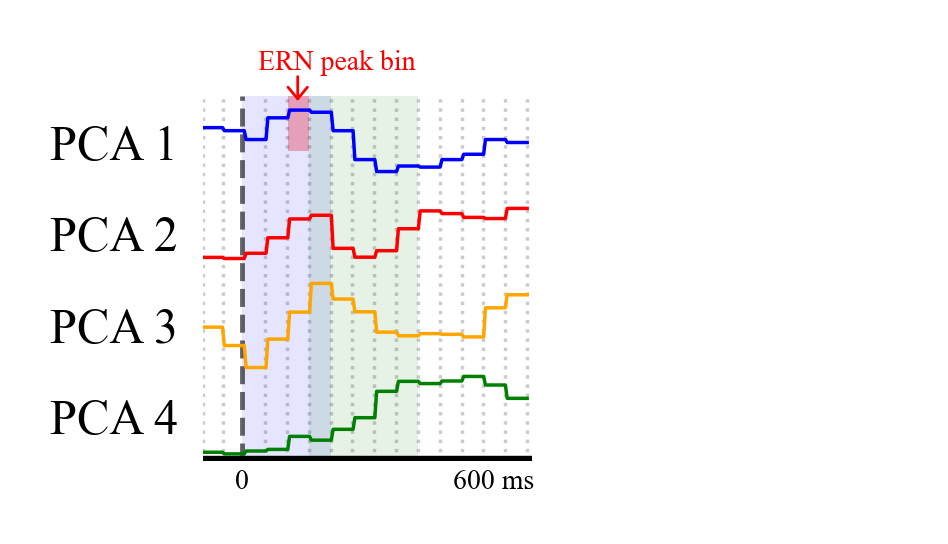

In [249]:
import matplotlib.ticker as ticker

cm = 1/2.54
dpi = 500

plt.rcParams['figure.dpi'] = dpi
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize'] = 7
plt.rcParams['xtick.labelsize'] = 7
plt.rcParams['axes.labelsize'] = 7
plt.rcParams["axes.edgecolor"] = ".15"
plt.rcParams["axes.linewidth"]  = 1
# plt.rcParams["figure.figsize"] = (5*cm, 5*cm)
plt.rc('font', size=7)
plt.rcParams["figure.frameon"] = False
    
# event_dict = {"correct_response": 0, "error_response": 1}

fig = patterns_epochs.plot(
    picks= ['PCA 1', 'PCA 2', 'PCA 3', 'PCA 4'],
    # event_id=event_dict,
    # event_color=dict(error_response="red"),
    scalings=dict(misc=50e-6),
    n_epochs=1,
    n_channels=4,
    # epoch_colors=[['blue']*4,['red']*4, ['orange']*4, ['green']*4, ['purple']*4,['pink']*4],
    epoch_colors=[['blue', 'red', 'orange', 'green']]*len(preprocessed_X_3),
    show_scrollbars=False,
    show_scalebars=False,
    show=False,
)
ax = fig.axes[0]

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.tick_params(size=0)
fig.axes[0].get_xaxis().set_visible(False)
fig.axes[0].get_xaxis().set_ticks([0.1,0.2, 0.3, 1.5])

ax.axvline(x=0.086, color='black', linestyle='--', linewidth = 0.7, alpha=0.6) ## 0

ax.axvline(x=0.0, color='black', linestyle='dotted', linewidth = 0.5, alpha=0.2)
ax.axvline(x=0.043, color='black', linestyle='dotted', linewidth = 0.5, alpha=0.2)

num=13
step=0.047
start=0.135

for i in np.arange(0,num)*step+start:
    ax.axvline(x=i, color='black', linestyle='dotted', linewidth = 0.5, alpha=0.2)


ax.hlines(3.5, 0, 0.71,  color='black', linestyle='-', linewidth = 1.5)

ax.text(0.07, 3.8, '0', fontsize = 4, zorder=100000000000, )
ax.text(0.54, 3.8, '600 ms', fontsize = 4, zorder=100000000000, )

ax.axvspan(0.183, 0.229, ymin=0.85, ymax=1, color='red', alpha=0.3, linestyle='-', linewidth=0)
# ax.axvline(x=0.18, color='red', linestyle='-', linewidth = 1, alpha=0.6)
ax.text(0.12, -0.8, f'ERN peak bin', fontsize = 4, zorder=100000000000, color='red')

ax.axvspan(0.086, 0.277, color='blue', alpha=0.1, linestyle='-', linewidth=0)
ax.axvspan(0.230, 0.465, color='green', alpha=0.1, linestyle='-', linewidth=0)
# ax.axvline(x=0.23, color='black', linestyle='-', linewidth = 1, alpha=0.2)

ax.annotate("", xy=(0.205, -0.3), xytext=(0.205, -0.87), arrowprops=dict(arrowstyle="->", color="red", linewidth=0.4, mutation_aspect=0.6),
            
           )

fig.set_size_inches(6*cm, 3.2*cm) 

plt.show()
fig.savefig(f'step_6_windows_spans_long_no_ticks_one_colors', bbox_inches='tight')

In [179]:
filter_ = preprocessed_pipeline['spatial_filter']

array([[-0.08958752, -0.18415617, -0.2715369 , -0.28437475, -0.27123328,
        -0.35571404, -0.32685231, -0.351545  , -0.32281407, -0.30444158,
        -0.23858388, -0.24951454, -0.23847353],
       [-0.37301944, -0.35752362, -0.29804253, -0.3097963 , -0.28735408,
        -0.17519554,  0.06977016,  0.07599271,  0.09910549,  0.26740702,
         0.32080011,  0.36051852,  0.33182362],
       [-0.56092591, -0.32861982, -0.00314074,  0.01560813, -0.05805947,
         0.42028708,  0.17379793,  0.28685732,  0.16086081, -0.08521778,
        -0.30304359, -0.28917145, -0.27571518],
       [ 0.55220007,  0.00986566, -0.2504976 , -0.26185703, -0.3672567 ,
        -0.04822591,  0.31075802,  0.41722289,  0.06228376,  0.22071919,
        -0.0991774 , -0.18159876, -0.24576492]])

In [ ]:
filter_.components_

In [175]:
preprocessed_X = preprocessed_pipeline.transform(X_train_df_copy)
preprocessed_X.shape

(96, 13, 181)


(96, 4, 181)

In [176]:
preprocessed_X_mean = np.mean(preprocessed_X, axis=0)

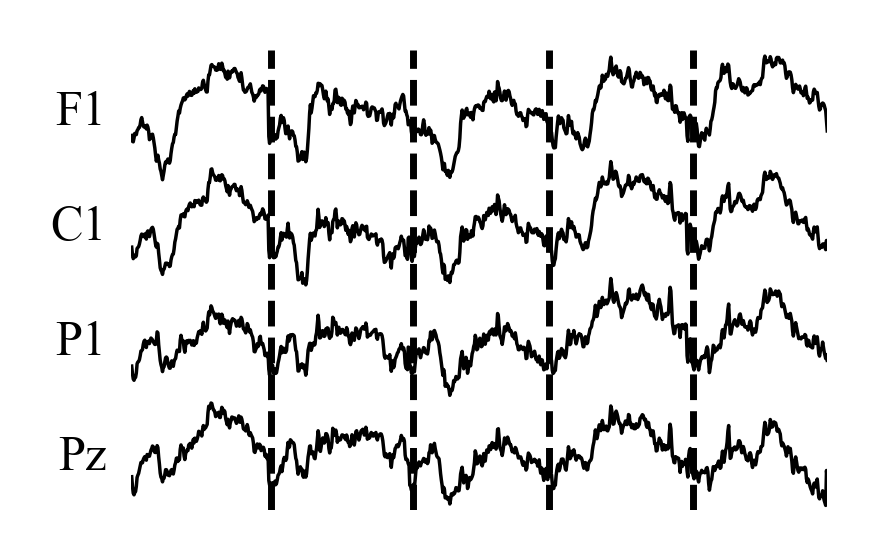

In [158]:
import matplotlib.ticker as ticker

cm = 1/2.54
dpi = 500

plt.rcParams['figure.dpi'] = dpi
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize'] = 7
plt.rcParams['xtick.labelsize'] = 7
plt.rcParams['axes.labelsize'] = 7
plt.rcParams["axes.edgecolor"] = ".15"
plt.rcParams["axes.linewidth"]  = 1
# plt.rcParams["figure.figsize"] = (5*cm, 5*cm)
plt.rc('font', size=7)
plt.rcParams["figure.frameon"] = False
    
event_dict = {"correct_response": 0, "error_response": 1}

fig = epochs['error_response'].plot(
    picks= roi_2,
    event_id=event_dict,
    event_color=dict(error_response="red"),
    scalings=dict(mag=1e-12, grad=4e-11, eeg=35e-6, eog=150e-6, ecg=5e-4,
     emg=1e-3, ref_meg=1e-12, misc=1e-3, stim=1,
     resp=1, chpi=1e-4, whitened=1e2),
    n_epochs=5,
    n_channels=4,
    epoch_colors=[['blue']*64,['red']*64, ['orange']*64, ['green']*64, ['purple']*64,['pink']*64],
    show_scrollbars=False,
    show_scalebars=False,
    show=False,
)
ax = fig.axes[0]

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.tick_params(size=0)
fig.axes[0].get_xaxis().set_visible(False)
fig.axes[0].get_xaxis().set_ticks([])

ax.axvline(x=0.71, color='black', linestyle='--', linewidth = 1, alpha=1)
ax.axvline(x=1.43, color='black', linestyle='--', linewidth = 1, alpha=1)
ax.axvline(x=2.12, color='black', linestyle='--', linewidth = 1, alpha=1)
ax.axvline(x=2.85, color='black', linestyle='--', linewidth = 1, alpha=1)


fig.set_size_inches(6*cm, 3.7*cm) 

plt.show()
# fig.savefig(f'step_1_roi_dark', bbox_inches='tight')

## Extract PCA-pipeline for both ERN ROIs

In [4]:
# ROI 1
roi_1_pipeline = results_ern.pre_processed_pipeline.iloc[9]
roi_1 = roi_1_pipeline['channels_extraction'].channels_list

print(roi_1_pipeline)
print(roi_1)

Pipeline(steps=[('channels_extraction',
                 PickChannels(channels_list=['Fpz', 'AFz', 'Fz', 'FCz', 'Cz',
                                             'CPz', 'P1', 'Pz', 'P2'])),
                ('average', Evoked()), ('extract_averaged_data', ExtractData()),
                ('spatial_filter_preprocessing', SpatialFilterPreprocessing()),
                ('spatial_filter', PCA(n_components=4, random_state=0)),
                ('spatial_filter_postprocessing',
                 SpatialFilterPostprocessing(timepoints_count=181)),
                ('lowpass_filter', LowpassFilter()),
                ('binning', BinTransformer()),
                ('centering', CenteredSignalAfterBaseline3())])
['Fpz', 'AFz', 'Fz', 'FCz', 'Cz', 'CPz', 'P1', 'Pz', 'P2']


In [5]:
# ROI 2
roi_2_pipeline = results_ern.pre_processed_pipeline.iloc[15]
roi_2 = roi_2_pipeline['channels_extraction'].channels_list

print(roi_2_pipeline)
print(roi_2)

Pipeline(steps=[('channels_extraction',
                 PickChannels(channels_list=['Fpz', 'AFz', 'F1', 'Fz', 'F2',
                                             'FCz', 'C1', 'Cz', 'C2', 'CPz',
                                             'P1', 'Pz', 'P2'])),
                ('average', Evoked()), ('extract_averaged_data', ExtractData()),
                ('spatial_filter_preprocessing', SpatialFilterPreprocessing()),
                ('spatial_filter', PCA(n_components=4, random_state=0)),
                ('spatial_filter_postprocessing',
                 SpatialFilterPostprocessing(timepoints_count=181)),
                ('lowpass_filter', LowpassFilter()),
                ('binning', BinTransformer()),
                ('centering', CenteredSignalAfterBaseline3())])
['Fpz', 'AFz', 'F1', 'Fz', 'F2', 'FCz', 'C1', 'Cz', 'C2', 'CPz', 'P1', 'Pz', 'P2']


## Extract PCA-pipeline for both Pe ROIs

In [7]:
# ROI 3
roi_3_pipeline = results_pe.pre_processed_pipeline.iloc[13]
roi_3 = roi_3_pipeline['channels_extraction'].channels_list

print(roi_3_pipeline)
print(roi_3)

Pipeline(steps=[('channels_extraction',
                 PickChannels(channels_list=['Fpz', 'AFz', 'Fz', 'FCz', 'C1',
                                             'Cz', 'C2', 'CPz', 'P1', 'Pz',
                                             'P2'])),
                ('average', Evoked()), ('extract_averaged_data', ExtractData()),
                ('spatial_filter_preprocessing', SpatialFilterPreprocessing()),
                ('spatial_filter', PCA(n_components=4, random_state=0)),
                ('spatial_filter_postprocessing',
                 SpatialFilterPostprocessing(timepoints_count=181)),
                ('lowpass_filter', LowpassFilter()),
                ('binning', BinTransformer()), ('baseline', ErnBaselined()),
                ('centering', CenteredSignalAfterBaseline3())])
['Fpz', 'AFz', 'Fz', 'FCz', 'C1', 'Cz', 'C2', 'CPz', 'P1', 'Pz', 'P2']


In [8]:
# ROI 4
roi_4_pipeline = results_pe.pre_processed_pipeline.iloc[1]
roi_4 = roi_4_pipeline['channels_extraction'].channels_list

print(roi_4_pipeline)
print(roi_4)

Pipeline(steps=[('channels_extraction',
                 PickChannels(channels_list=['Fpz', 'AFz', 'F1', 'Fz', 'F2',
                                             'FC1', 'FCz', 'FC2', 'C1', 'Cz',
                                             'C2', 'CP1', 'CPz', 'CP2', 'P1',
                                             'Pz', 'P2'])),
                ('average', Evoked()), ('extract_averaged_data', ExtractData()),
                ('spatial_filter_preprocessing', SpatialFilterPreprocessing()),
                ('spatial_filter', PCA(n_components=4, random_state=0)),
                ('spatial_filter_postprocessing',
                 SpatialFilterPostprocessing(timepoints_count=181)),
                ('lowpass_filter', LowpassFilter()),
                ('binning', BinTransformer()), ('baseline', ErnBaselined()),
                ('centering', CenteredSignalAfterBaseline3())])
['Fpz', 'AFz', 'F1', 'Fz', 'F2', 'FC1', 'FCz', 'FC2', 'C1', 'Cz', 'C2', 'CP1', 'CPz', 'CP2', 'P1', 'Pz', 'P2']


---

## Load data

In [11]:
df_name = "go_nogo_100_600_df_3-5_all_scales"
pickled_data_filename = "../data/responses_100_600_pickled/" + df_name + ".pkl"
info_filename = "../data/scales/all_scales.csv"

if os.path.isfile(pickled_data_filename):
    print("Pickled file found. Loading pickled data...")
    epochs_df = pd.read_pickle(pickled_data_filename)
    print("Done")
    pass
else:
    print("Pickled file not found")

Pickled file found. Loading pickled data...
Done


In [12]:
X_train_df = epochs_df

---

## Visualize channels in ROIs

In [18]:
def plot_roi(channels_list, roi_name, save=False):
    cm = 1/2.54
    dpi = 200

    plt.rcParams['figure.dpi'] = dpi
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams['ytick.labelsize'] = 7
    plt.rcParams['xtick.labelsize'] = 7
    plt.rcParams['axes.labelsize'] = 9
    plt.rcParams["axes.edgecolor"] = ".15"
    plt.rcParams["axes.linewidth"]  = 1
    plt.rc('font', size=7)

    sns.set_palette('deep')
    palette = sns.color_palette("tab10")
    red = palette[3]


    X_df = X_train_df
    X_df_copy = pd.DataFrame(copy.deepcopy(X_df.to_dict()))

    epochs_full = mne.concatenate_epochs([epoch['error_response'] for epoch in epochs_df.epoch.to_list()])

    channels = epochs_full[0].info['ch_names']
    mask = np.isin(channels, channels_list)
    mask = mask.reshape(mask.shape[0], -1) 
    mask = np.repeat(mask, 181, axis=1)


    evoked_array = mne.EvokedArray(np.zeros((64,181)), epochs_full.info)

    mask_params = dict(
        marker='o', 
        markerfacecolor=red, 
        markeredgecolor=red,
        linewidth=0, 
        markersize=12
    )

    fig = evoked_array.plot_topomap(
        times=0, 
        mask=mask,
        # show_names=True,
        cmap='binary',
        show=False,
        colorbar=False, 
        mask_params=mask_params,
        outlines='head',
        sphere='auto'
    )
    axis = fig.axes[0]
    axis.set_title('')

    fig.set_size_inches(5*cm, 5*cm) 

    plt.show()

    if save:
        fig.savefig(f'roi_{roi_name}_dpi_{dpi}_color', bbox_inches='tight')
    

Not setting metadata
1635 matching events found
No baseline correction applied


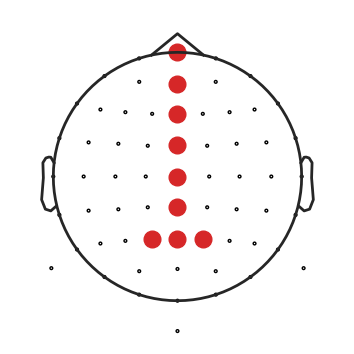

In [19]:
# ROI 1
plot_roi(roi_1, "1", save=False)

Not setting metadata
1635 matching events found
No baseline correction applied


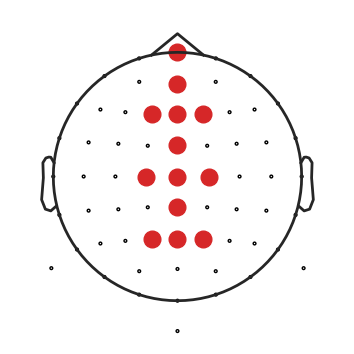

In [20]:
# ROI 2
plot_roi(roi_2, "2", save=False)

Not setting metadata
1635 matching events found
No baseline correction applied


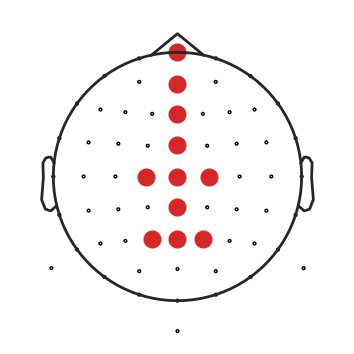

In [21]:
# ROI 3
plot_roi(roi_3, "3", save=False)

Not setting metadata
1635 matching events found
No baseline correction applied


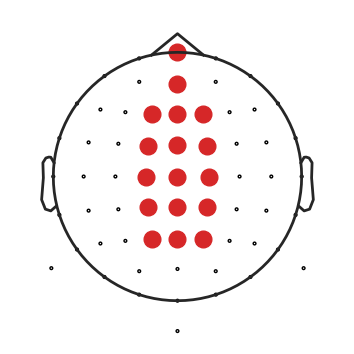

In [22]:
# ROI 4
plot_roi(roi_4, "4", save=False)

---

## Visualize components' patterns and filters

In [13]:
def setup_patterns_and_filters_for_plotting(X_patterns, X_filters, epochs):
    
    patterns_evokes = np.array([mne.EvokedArray(pattern, epochs.info, tmin=epochs.tmin) for pattern in X_patterns])
    patterns_grand_averages = np.array([np.mean(pattern.get_data(), axis=0) for pattern in patterns_evokes])
    
    filters_evokes = np.array([mne.EvokedArray(filter_, epochs.info) for filter_ in X_filters])
    filters_ = np.array([filter_.get_data().reshape(-1) for filter_ in filters_evokes])
    
    ########################################################################################
    patterns_df = pd.DataFrame()

    for index, pattern in enumerate(patterns_grand_averages):
        this_pattern = pd.DataFrame()
        this_pattern['Time'] = np.linspace(-0.1,0.6,181)
        this_pattern['Voltage'] = pattern *1000000 # resale to uV
        this_pattern['PCA'] = len(pattern)*np.array(0) + index + 1
        
        patterns_df = pd.concat([patterns_df, this_pattern])
        
    
    return patterns_df, patterns_evokes, filters_, filters_evokes

In [14]:
def extract_filters_patterns(roi_pipeline, roi, X):
    X_df_copy = pd.DataFrame(copy.deepcopy(X.to_dict()))

    # extract PCA components (eigenvectors)
    components = roi_pipeline['spatial_filter'].components_

    # create MNE object with sensors within ROI
    epochs_full = mne.concatenate_epochs([epoch['error_response'] for epoch in X.epoch.to_list()])
    epochs_full = epochs_full.pick_channels(roi, ordered=True)

    # compute grand average of EEG signal within ROI
    evokeds = np.array([epoch['error_response'].average() for epoch in X.epoch.to_list()])
    X_channels_mean = np.mean(np.array([evoked.get_data(picks=roi) for evoked in evokeds]), axis=0)


    # center data
    X_channels_mean_t = X_channels_mean.T
    m = np.mean(X_channels_mean_t, axis=0)
    X_channels_mean_t -= m   

    # create components scores (patterns)
    X_patterns = np.array([(X_channels_mean_t * component).T for component in components])
    
    # create filters (simply weights)
    X_filters = np.array([component.reshape(X_channels_mean.shape[0],-1) for component in components])
    
    patterns_df, patterns_evokes, filters_, filters_evokes = setup_patterns_and_filters_for_plotting(X_patterns, X_filters, epochs_full)
    
    return patterns_df, patterns_evokes, filters_, filters_evokes  

In [23]:
def plot_ern_patterns_filters(patterns_df, patterns_evokes, filters_, filters_evoked, roi_name, save=False):
    cm = 1/2.54
    dpi = 200

    plt.rcParams['figure.dpi'] = dpi
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams['ytick.labelsize'] = 7
    plt.rcParams['xtick.labelsize'] = 7
    plt.rcParams['axes.labelsize'] = 9
    plt.rcParams["axes.edgecolor"] = ".15"
    plt.rcParams["axes.linewidth"]  = 0.5

    sns.set_palette('deep')

    g = sns.FacetGrid(
        data=patterns_df, 
        col='PCA', 
        sharey=False, 
        despine=False,
        gridspec_kws={"wspace":0.25}
    )


    g.map(sns.lineplot, 'Time', 'Voltage')

    g.set(xlim=(-0.106, 0.405))
    g.set(xticks=np.arange(-0.1,0.5,0.1))

    # set y axes limits
    axes = g.axes.flatten()

    # ERN ROI smaller
    axes[0].set_ylim([-3.3, 4.3])
    axes[1].set_ylim([-1.2, 1.5])
    axes[2].set_ylim([-0.6, 0.6])
    axes[3].set_ylim([-0.11, 0.11])


    fig = g.fig
    ################################################################
    ############## ADD FILTERS #####################################

    # first filter
    filter_0_axis = fig.add_axes([0.017,0.73,0.08,0.21], anchor='NE', zorder=2)
    filter_topo, contours = mne.viz.plot_topomap(filters_[0], filters_evoked[0].info, show=False, axes=filter_0_axis, res=1000, contours=3)
    # # settings for filter topo
    plt.setp(contours.collections , linewidth=0.2)
    plt.setp(filter_0_axis.lines , linewidth=0.5)


    # second filter
    filter_1_axis = fig.add_axes([0.254,0.73,0.08,0.21], anchor='NE', zorder=2)
    filter_topo, contours = mne.viz.plot_topomap(filters_[1], filters_evoked[1].info, show=False, axes=filter_1_axis, res=1000, contours=3)
    # # settings for filter topo
    plt.setp(contours.collections , linewidth=0.2)
    plt.setp(filter_1_axis.lines , linewidth=0.5)

    # third filter
    filter_2_axis = fig.add_axes([0.491,0.73,0.08,0.21], anchor='NE', zorder=2)
    filter_topo, contours = mne.viz.plot_topomap(filters_[2], filters_evoked[2].info, show=False, axes=filter_2_axis, res=1000, contours=3)
    # # settings for filter topo
    plt.setp(contours.collections , linewidth=0.2)
    plt.setp(filter_2_axis.lines , linewidth=0.5)

    # fourth filter
    filter_3_axis = fig.add_axes([0.728,0.73,0.08,0.21], anchor='NE', zorder=2)
    filter_topo, contours = mne.viz.plot_topomap(filters_[3], filters_evoked[3].info, show=False, axes=filter_3_axis, res=1000, contours=3)
    # # settings for filter topo
    plt.setp(contours.collections , linewidth=0.2)
    plt.setp(filter_3_axis.lines , linewidth=0.5)



    ################################################################
    ############## ADD PATTERNS #####################################

    pattern_0_axis = fig.add_axes([0.146,0.58,0.09,0.27], anchor='NE', zorder=10)
    pattern_0_axis_cbar = fig.add_axes([0.1,0.12,0.15,0.1], anchor='NE', zorder=10)

    pattern_1_axis = fig.add_axes([0.383,0.58,0.09,0.27], anchor='NE', zorder=2)
    # pattern_1_axis_cbar = fig.add_axes([0.1,0.12,0.15,0.1], anchor='NE', zorder=2)

    pattern_2_axis = fig.add_axes([0.621,0.58,0.09,0.27], anchor='NE', zorder=2)
    # pattern_2_axis_cbar = fig.add_axes([0.1,0.12,0.15,0.1], anchor='NE', zorder=2)

    pattern_3_axis = fig.add_axes([0.857,0.58,0.09,0.27], anchor='NE', zorder=2)
    # pattern_3_axis_cbar = fig.add_axes([0.1,0.12,0.15,0.1], anchor='NE', zorder=2)


    pattern_0_topo = patterns_evokes[0].plot_topomap(
        times = [0.04], 
        show=False, 
        vmin = -5, 
        vmax = 4,
        axes=[pattern_0_axis,pattern_0_axis_cbar],
        outlines='skirt',
    )


    pattern_1_topo = patterns_evokes[1].plot_topomap(
        times = [0.04], 
        show=False, 
        vmin = -5, 
        vmax = 4,
        axes=[pattern_1_axis,pattern_0_axis_cbar],
        outlines='skirt',
    )

    pattern_2_topo = patterns_evokes[2].plot_topomap(
        times = [0.03], 
        show=False, 
        vmin = -5, 
        vmax = 4,
        axes=[pattern_2_axis,pattern_0_axis_cbar],
        outlines='skirt',
    )

    pattern_3_topo = patterns_evokes[3].plot_topomap(
        times = [0.055], 
        show=False, 
        vmin = -5, 
        vmax = 4,
        axes=[pattern_3_axis, pattern_0_axis_cbar],
        outlines='skirt',
    )


    # remove cbars
    pattern_0_axis_cbar.remove()


    # settings for pattern topo
    plt.setp(pattern_0_axis.lines , linewidth=0.5)
    pattern_0_axis.set_title('0.04 s', size=7, pad=4) # Title

    # settings for pattern topo
    plt.setp(pattern_1_axis.lines , linewidth=0.5)
    pattern_1_axis.set_title('0.04 s', size=7, pad=4) # Title

    plt.setp(pattern_2_axis.lines , linewidth=0.5)
    pattern_2_axis.set_title('0.03 s', size=7, pad=4) # Title

    plt.setp(pattern_3_axis.lines , linewidth=0.5)
    pattern_3_axis.set_title('0.05 s', size=7, pad=4) # Title


    # add vlines
    axes[0].axvline(x=0.04, color='grey', linestyle='--', linewidth = 1, alpha=0.5)
    axes[1].axvline(x=0.04, color='grey', linestyle='--', linewidth = 1, alpha=0.5)
    axes[2].axvline(x=0.03, color='grey', linestyle='--', linewidth = 1, alpha=0.5)
    axes[3].axvline(x=0.055, color='grey', linestyle='--', linewidth = 1, alpha=0.5)

    # set labels
    axes[0].set(xlabel="Time (s)", ylabel='Voltage (μV)')
    axes[1].set(xlabel="Time (s)")
    axes[2].set(xlabel="Time (s)")
    axes[3].set(xlabel="Time (s)")


    # set figure size
    fig.set_size_inches(19*cm, 3.8*cm)
    
    plt.show()

    if save:
        fig.savefig(f'ern_roi_{roi_name}_dpi_{dpi}', bbox_inches='tight')

In [24]:
def plot_pe_patterns_filters(patterns_df, patterns_evokes, filters_, filters_evoked, roi_name, save=False):
    cm = 1/2.54
    dpi = 200

    plt.rcParams['figure.dpi'] = dpi
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams['ytick.labelsize'] = 7
    plt.rcParams['xtick.labelsize'] = 7
    plt.rcParams['axes.labelsize'] = 9
    plt.rcParams["axes.edgecolor"] = ".15"
    plt.rcParams["axes.linewidth"]  = 0.5

    sns.set_palette('deep')

    g = sns.FacetGrid(
        data=patterns_df, 
        col='PCA', 
        sharey=False, 
        despine=False,
        gridspec_kws={"wspace":0.25}
    )


    g.map(sns.lineplot, 'Time', 'Voltage')

    g.set(xlim=(-0.106, 0.405))
    g.set(xticks=np.arange(-0.1,0.5,0.1))

    # set y axes limits
    axes = g.axes.flatten()

    # Pe ROI smaller
    axes[0].set_ylim([-3.3, 4.3])
    axes[1].set_ylim([-1.2, 1.5])
    axes[2].set_ylim([-0.6, 0.6])
    axes[3].set_ylim([-0.11, 0.13])


    fig = g.fig
    ################################################################
    ############## ADD FILTERS #####################################

    # first filter
    filter_0_axis = fig.add_axes([0.017,0.73,0.08,0.21], anchor='NE', zorder=2)
    filter_topo, contours = mne.viz.plot_topomap(filters_[0], filters_evoked[0].info, show=False, axes=filter_0_axis, res=1000, contours=3)
    # # settings for filter topo
    plt.setp(contours.collections , linewidth=0.2)
    plt.setp(filter_0_axis.lines , linewidth=0.5)


    # second filter
    filter_1_axis = fig.add_axes([0.254,0.73,0.08,0.21], anchor='NE', zorder=2)
    filter_topo, contours = mne.viz.plot_topomap(filters_[1], filters_evoked[1].info, show=False, axes=filter_1_axis, res=1000, contours=3)
    # # settings for filter topo
    plt.setp(contours.collections , linewidth=0.2)
    plt.setp(filter_1_axis.lines , linewidth=0.5)

    # third filter
    filter_2_axis = fig.add_axes([0.491,0.73,0.08,0.21], anchor='NE', zorder=2)
    filter_topo, contours = mne.viz.plot_topomap(filters_[2], filters_evoked[2].info, show=False, axes=filter_2_axis, res=1000, contours=3)
    # # settings for filter topo
    plt.setp(contours.collections , linewidth=0.2)
    plt.setp(filter_2_axis.lines , linewidth=0.5)

    # fourth filter
    filter_3_axis = fig.add_axes([0.728,0.73,0.08,0.21], anchor='NE', zorder=2)
    filter_topo, contours = mne.viz.plot_topomap(filters_[3], filters_evoked[3].info, show=False, axes=filter_3_axis, res=1000, contours=3)
    # # settings for filter topo
    plt.setp(contours.collections , linewidth=0.2)
    plt.setp(filter_3_axis.lines , linewidth=0.5)



    ################################################################
    ############## ADD PATTERNS #####################################

    pattern_0_axis = fig.add_axes([0.146,0.58,0.09,0.27], anchor='NE', zorder=10)
    pattern_0_axis_cbar = fig.add_axes([0.1,0.12,0.15,0.1], anchor='NE', zorder=10)

    pattern_1_axis = fig.add_axes([0.383,0.58,0.09,0.27], anchor='NE', zorder=2)
    # pattern_1_axis_cbar = fig.add_axes([0.1,0.12,0.15,0.1], anchor='NE', zorder=2)

    pattern_2_axis = fig.add_axes([0.621,0.58,0.09,0.27], anchor='NE', zorder=2)
    # pattern_2_axis_cbar = fig.add_axes([0.1,0.12,0.15,0.1], anchor='NE', zorder=2)

    pattern_3_axis = fig.add_axes([0.857,0.58,0.09,0.27], anchor='NE', zorder=2)
    # pattern_3_axis_cbar = fig.add_axes([0.1,0.12,0.15,0.1], anchor='NE', zorder=2)


    pattern_0_topo = patterns_evokes[0].plot_topomap(
        times = [0.22], 
        show=False, 
        vmin = -5, 
        vmax = 4,
        axes=[pattern_0_axis,pattern_0_axis_cbar],
        outlines='skirt',
    )


    pattern_1_topo = patterns_evokes[1].plot_topomap(
        times = [0.2], 
        show=False, 
        vmin = -5, 
        vmax = 4,
        axes=[pattern_1_axis,pattern_0_axis_cbar],
        outlines='skirt',
    )

    pattern_2_topo = patterns_evokes[2].plot_topomap(
        times = [0.17], 
        show=False, 
        vmin = -5, 
        vmax = 4,
        axes=[pattern_2_axis,pattern_0_axis_cbar],
        outlines='skirt',
    )

    pattern_3_topo = patterns_evokes[3].plot_topomap(
        times = [0.18], 
        show=False, 
        vmin = -5, 
        vmax = 4,
        axes=[pattern_3_axis, pattern_0_axis_cbar],
        outlines='skirt',
    )


    # remove cbars
    pattern_0_axis_cbar.remove()


    # settings for pattern topo
    plt.setp(pattern_0_axis.lines , linewidth=0.5)
    pattern_0_axis.set_title('0.22 s', size=7, pad=4) # Title

    # settings for pattern topo
    plt.setp(pattern_1_axis.lines , linewidth=0.5)
    pattern_1_axis.set_title('0.20 s', size=7, pad=4) # Title

    plt.setp(pattern_2_axis.lines , linewidth=0.5)
    pattern_2_axis.set_title('0.17 s', size=7, pad=4) # Title

    plt.setp(pattern_3_axis.lines , linewidth=0.5)
    pattern_3_axis.set_title('0.18 s', size=7, pad=4) # Title


    # add vlines
    axes[0].axvline(x=0.22, color='grey', linestyle='--', linewidth = 1, alpha=0.5)
    axes[1].axvline(x=0.2, color='grey', linestyle='--', linewidth = 1, alpha=0.5)
    axes[2].axvline(x=0.17, color='grey', linestyle='--', linewidth = 1, alpha=0.5)
    axes[3].axvline(x=0.18, color='grey', linestyle='--', linewidth = 1, alpha=0.5)

    # set labels
    axes[0].set(xlabel="Time (s)", ylabel='Voltage (μV)')
    axes[1].set(xlabel="Time (s)")
    axes[2].set(xlabel="Time (s)")
    axes[3].set(xlabel="Time (s)")


    # set figure size
    fig.set_size_inches(19*cm, 3.8*cm)
    
    plt.show()

    if save:
        fig.savefig(f'pe_roi_{roi_name}_dpi_{dpi}', bbox_inches='tight')

## Plot ERN patterns and filters

#### ERN ROI 1

In [33]:
patterns_df, patterns_evokes, filters_, filters_evokes = extract_filters_patterns(
    roi_1_pipeline, 
    roi_1, 
    X_train_df
)

Not setting metadata
1635 matching events found
No baseline correction applied


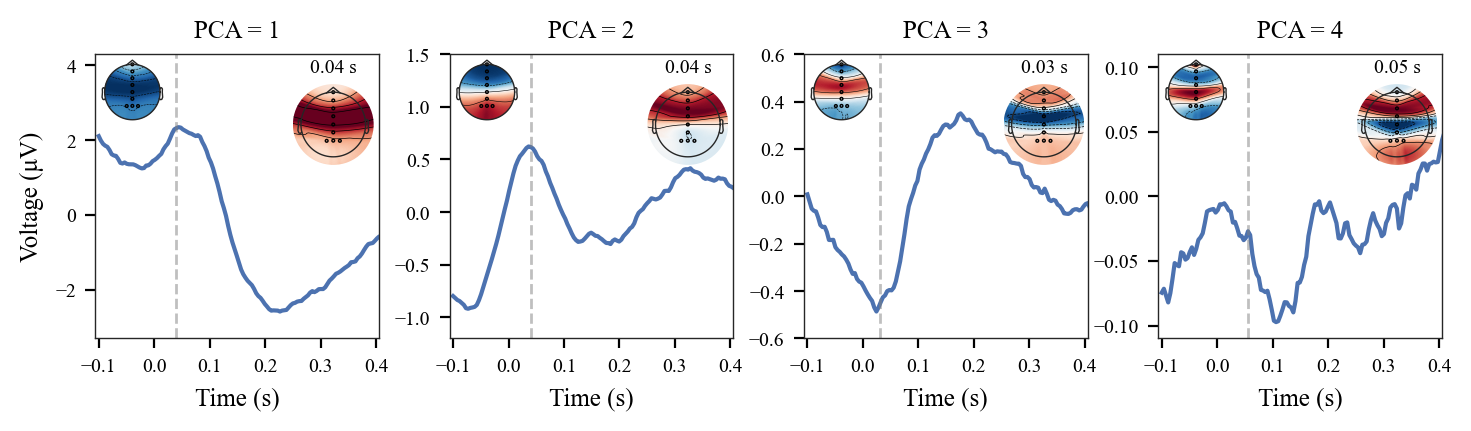

In [34]:
plot_ern_patterns_filters(
    patterns_df, 
    patterns_evokes, 
    filters_, 
    filters_evoke, 
    roi_name='1', 
    save=False
)

#### ERN ROI 2

In [35]:
patterns_df, patterns_evokes, filters_, filters_evokes = extract_filters_patterns(
    roi_2_pipeline, 
    roi_2, 
    X_train_df
)

Not setting metadata
1635 matching events found
No baseline correction applied


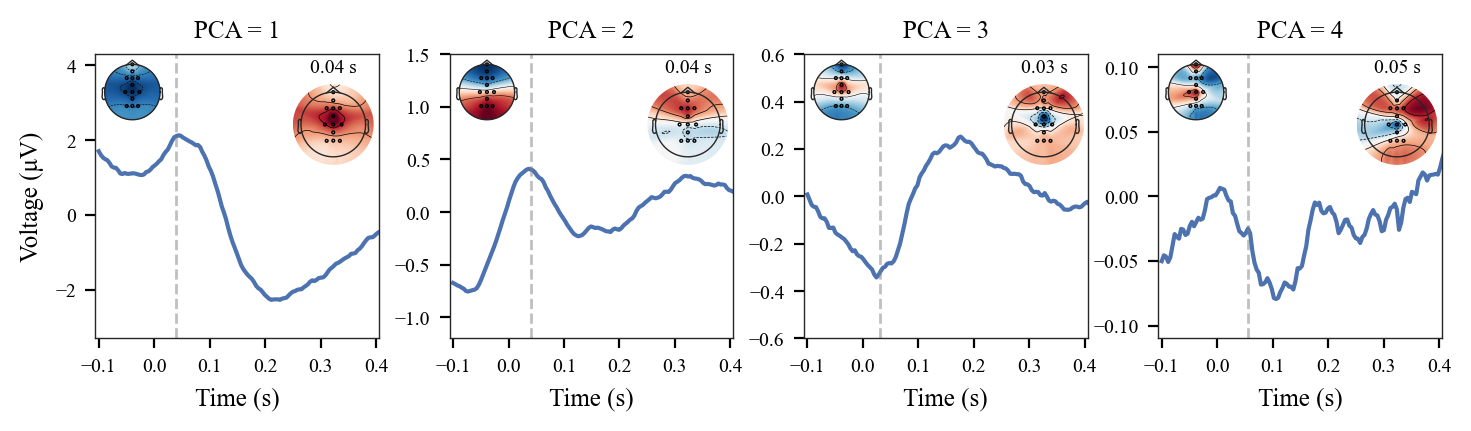

In [36]:
plot_ern_patterns_filters(
    patterns_df, 
    patterns_evokes, 
    filters_, 
    filters_evokes, 
    roi_name='2', 
    save=False
)

## Plot Pe patterns and filters

#### Pe ROI 3

In [69]:
patterns_df, patterns_evokes, filters_, filters_evokes = extract_filters_patterns(
    roi_3_pipeline, 
    roi_3, 
    X_train_df
)

Not setting metadata
1635 matching events found
No baseline correction applied


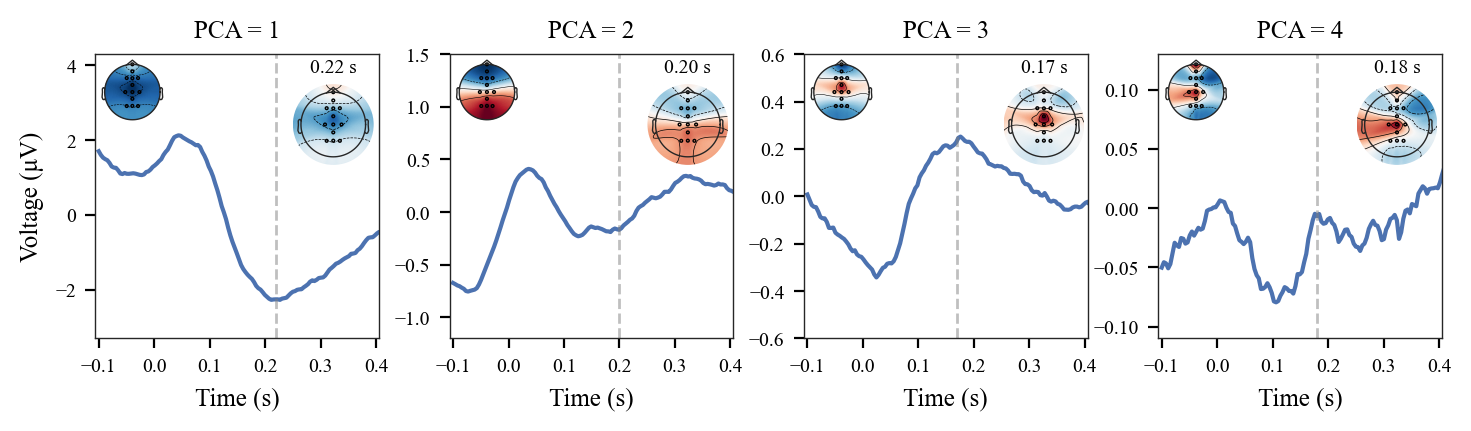

In [37]:
plot_pe_patterns_filters(
    patterns_df, 
    patterns_evokes, 
    filters_, 
    filters_evokes, 
    roi_name='3', 
    save=False
)

#### Pe ROI 4

In [40]:
patterns_df, patterns_evokes, filters_, filters_evokes = extract_filters_patterns(
    roi_4_pipeline, 
    roi_4, 
    X_train_df
)

Not setting metadata
1635 matching events found
No baseline correction applied


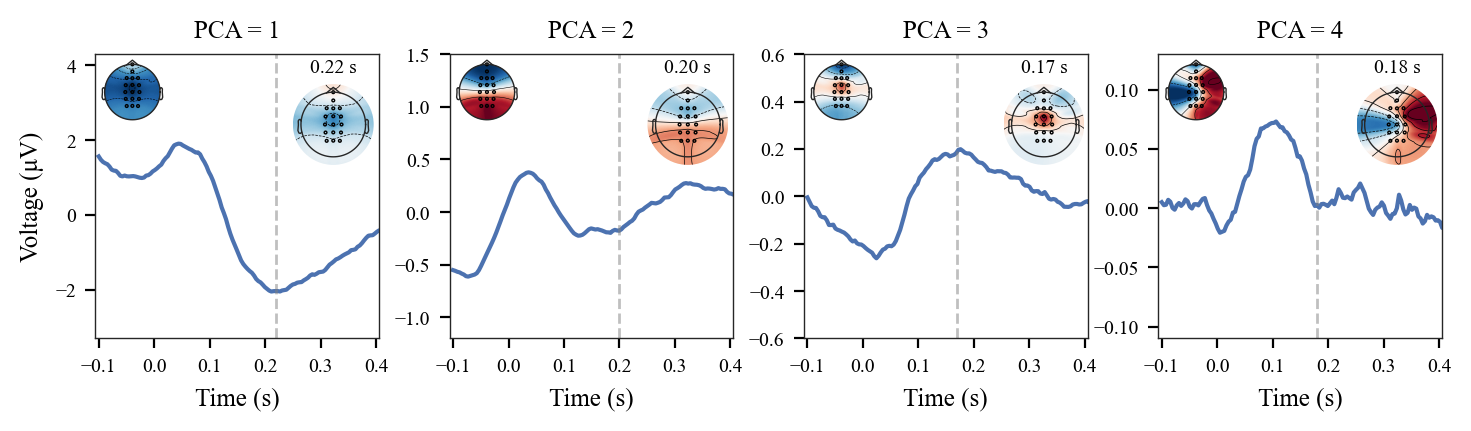

In [41]:
plot_pe_patterns_filters(
    patterns_df, 
    patterns_evokes, 
    filters_, 
    filters_evokes, 
    roi_name='4', 
    save=False
)